In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid", palette="Set2")
sns.set_context("paper")
plt.rcParams['savefig.dpi'] = 300

CONLL_CSS_PATH = Path("data", "wandb_conll_baseline_sweep.csv")
WNUT_CSS_PATH = Path("data", "wandb_wnut_baseline_sweep.csv")
WNUT_CSS_BS64_PATH = Path("data", "wandb_wnut_bs64_baseline_sweep.csv")
MIT_CSS_PATH = Path("data", "wandb_mit_baseline_sweep.csv")

In [47]:
conll_df = pd.read_csv(CONLL_CSS_PATH)
conll_df["corpus"] = "CONLL_2003"

wnut_df = pd.read_csv(WNUT_CSS_PATH)
wnut_df["corpus"] = "WNUT_2017"

wnut_bs64_df = pd.read_csv(WNUT_CSS_BS64_PATH)
wnut_bs64_df["corpus"] = "WNUT_2017"

mit_df = pd.read_csv(MIT_CSS_PATH)
mit_df["corpus"] = "MIT_ENGLISH_RESTAURANT"

frames = [conll_df, wnut_df, mit_df]
df = pd.concat(frames).sort_values(by=["corpus", "run_type"]).reset_index(drop=True)

In [48]:
medians = []
for _, corpus_df in df.groupby('corpus'):
    baseline_score = np.nanmedian(corpus_df[corpus_df['run_type'] == 'baseline']['test_score'].values)
    contrastive_score = np.nanmedian(corpus_df[corpus_df['run_type'] == 'contrastive']['test_score'].values)
    medians.append((baseline_score, contrastive_score))

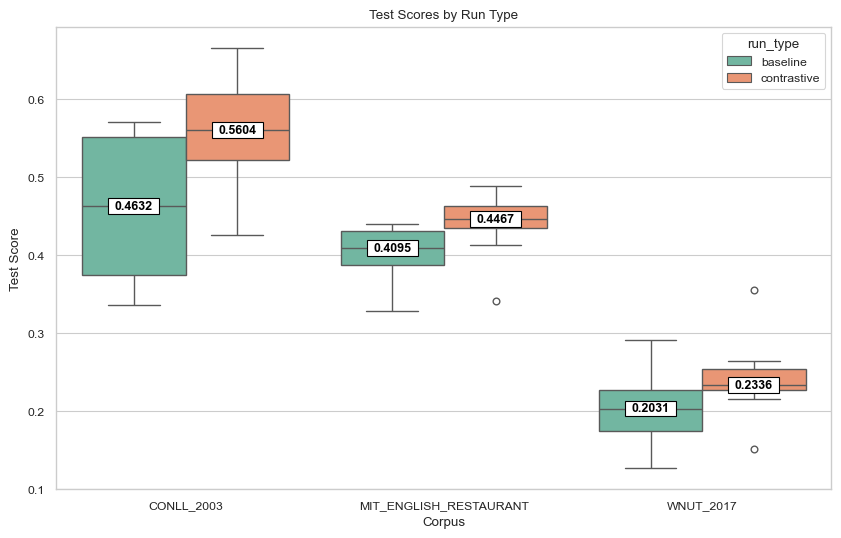

In [49]:
X_SIZE = 10
Y_SIZE = 6

plt.figure(figsize=(X_SIZE, Y_SIZE))

box_plot = sns.boxplot(x='corpus', y='test_score', data=df, hue='run_type')

plt.title('Test Scores by Run Type')
plt.xlabel('Corpus')
plt.ylabel('Test Score')

plt.subplots_adjust(wspace=0.5)

# Get the current axis
ax = plt.gca()

# Calculate the vertical offset based on the plot size
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
vertical_offset = y_range * 0.01 

x_margin = X_SIZE = 0.025
y_margin = Y_SIZE = 0.0025

sub = True
for xtick in box_plot.get_xticks():
    for median in medians[xtick]:
        text = ax.text(
            xtick-0.2 if sub else xtick+0.2, 
            median,
            f'{median:.4f}', 
            horizontalalignment='center',
            verticalalignment='center',
            size=9,
            color='black',
            weight='semibold'
        )
        
        # Get the bounding box of the text
        bbox = text.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
        
        # Convert bbox to data coordinates
        bbox_data = bbox.transformed(ax.transData.inverted())
        
        rect = plt.Rectangle((bbox_data.x0 - x_margin, bbox_data.y0 - y_margin), 
                             bbox_data.width + 2*x_margin, 
                             bbox_data.height + 2*y_margin, 
                             facecolor='white', 
                             edgecolor='black', 
                             # alpha=0.7, 
                             zorder=3)
        
        ax.add_patch(rect)
        
        # Bring the text to the front
        text.set_zorder(4)
        sub = not sub
    

save_path = Path(os.getcwd(), "output_figs", "baseline_contrastive_experiment_fig.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [5]:
wnut_df["test_score"].isna().sum()

np.int64(9)

In [5]:
relevant_full_df = full_df[["run_type", "test_score", "corpus"]]
relevant_conll_df = conll_df[["run_type", "test_score", "corpus"]]
relevant_wnut_df = wnut_df[["run_type", "test_score", "corpus"]]
relevant_mit_df = mit_df[["run_type", "test_score", "corpus"]]

In [20]:
def stats_per_experiment(df) -> pd.DataFrame:
    corpus = df.loc[0, "corpus"].replace("_", " ")
    mean_contrastive = df[df["run_type"] == "contrastive"]["test_score"].mean()
    std_contrastive = df[df["run_type"] == "contrastive"]["test_score"].std()
    median_contrastive = df[df["run_type"] == "contrastive"]["test_score"].median()
    mean_baseline = df[df["run_type"] == "baseline"]["test_score"].mean()
    std_baseline = df[df["run_type"] == "baseline"]["test_score"].std()
    median_baseline = df[df["run_type"] == "baseline"]["test_score"].median()
    mean_diff = abs(mean_contrastive - mean_baseline)
    median_diff = abs(median_contrastive - median_baseline)
    higher_score = "ContrastNER" if mean_contrastive >= mean_baseline else "Baseline"

    # Create the DataFrame
    df = pd.DataFrame({
        "Parameter": ["Mean ContrastNER",  "Mean Baseline", "Mean Difference", "Median Contrastive", "Median Baseline", "Median Difference", "STD Contrastner", "STD Baseline", "Higher Test Score"],
        corpus: [mean_contrastive, mean_baseline, mean_diff, median_contrastive, median_baseline, median_diff, std_contrastive, std_baseline, higher_score]
    })
    
    # Set "Parameter" as the index
    df.set_index("Parameter", inplace=True)
    return df


stats_df = stats_per_experiment(conll_df).join(stats_per_experiment(wnut_df)).join(stats_per_experiment(mit_df))
stats_df

,CONLL 2003,WNUT 2017,MIT ENGLISH RESTAURANT
Parameter,,,
Mean ContrastNER,0.558415,0.241271,0.444502
Mean Baseline,0.460246,0.205045,0.404742
Mean Difference,0.098169,0.036225,0.03976
Median Contrastive,0.560442,0.233622,0.446677
Median Baseline,0.463159,0.203098,0.409486
Median Difference,0.097283,0.030524,0.037191
STD Contrastner,0.061606,0.048445,0.031927
STD Baseline,0.089139,0.041195,0.032329
Higher Test Score,ContrastNER,ContrastNER,ContrastNER


In [75]:
# Remove rows with NaN values in 'test_score'
df = full_df.dropna(subset=['test_score'])

# Group the DataFrame by 'corpus' and 'run_type', and calculate statistics for 'test_score'
stats = df.groupby(['corpus', 'run_type'])['test_score'].agg(['median', 'mean', 'std'])

# Rename the columns for clarity
stats.columns = ['Median', 'Mean', 'Standard Deviation']

# Round the results to 4 decimal places
stats = stats.round(4)

# Reshape the DataFrame to have 'run_type' as columns
stats_reshaped = stats.unstack(level='run_type')

# Flatten column names
stats_reshaped.columns = [' '.join(col).strip() for col in stats_reshaped.columns.values]
stats_reshaped.columns = stats_reshaped.columns.str.title()
stats_reshaped.columns = stats_reshaped.columns.str.replace("Contrastive", "ContrastNER")

# Display the results
stats_reshaped = stats_reshaped.T
stats_reshaped.columns = stats_reshaped.columns.str.replace("_", " ")
stats_reshaped_styler = stats_reshaped.style.format(precision=4)
stats_reshaped_styler

corpus,CONLL 2003,MIT ENGLISH RESTAURANT,WNUT 2017
Median Baseline,0.4632,0.4095,0.2031
Median ContrastNER,0.5604,0.4467,0.2336
Mean Baseline,0.4602,0.4047,0.2050
Mean ContrastNER,0.5584,0.4445,0.2413
Standard Deviation Baseline,0.0891,0.0323,0.0412
Standard Deviation ContrastNER,0.0616,0.0319,0.0484


In [76]:
print(stats_reshaped_styler.to_latex())

\begin{tabular}{lrrr}
corpus & CONLL 2003 & MIT ENGLISH RESTAURANT & WNUT 2017 \\
Median Baseline & 0.4632 & 0.4095 & 0.2031 \\
Median ContrastNER & 0.5604 & 0.4467 & 0.2336 \\
Mean Baseline & 0.4602 & 0.4047 & 0.2050 \\
Mean ContrastNER & 0.5584 & 0.4445 & 0.2413 \\
Standard Deviation Baseline & 0.0891 & 0.0323 & 0.0412 \\
Standard Deviation ContrastNER & 0.0616 & 0.0319 & 0.0484 \\
\end{tabular}



In [84]:
diff_cont = stats_reshaped.T.filter(like='ContrastNER')
diff_cont.columns = ["median", "mean", "std"]

diff_base = stats_reshaped.T.filter(like='Baseline')
diff_base.columns = ["median", "mean", "std"]

diff = diff_cont - diff_base
diff = diff.iloc[:, 0:2]
diff.columns = ["Advantage Median", "Advantage Mean"]
diff_styler = diff.style.format(precision=4)
diff_styler

,Advantage Median,Advantage Mean
corpus,,
CONLL 2003,0.0972,0.0982
MIT ENGLISH RESTAURANT,0.0372,0.0398
WNUT 2017,0.0305,0.0363


In [85]:
print(diff_styler.to_latex())

\begin{tabular}{lrr}
 & Advantage Median & Advantage Mean \\
corpus &  &  \\
CONLL 2003 & 0.0972 & 0.0982 \\
MIT ENGLISH RESTAURANT & 0.0372 & 0.0398 \\
WNUT 2017 & 0.0305 & 0.0363 \\
\end{tabular}



In [72]:
print(stats_df.to_latex())


\begin{tabular}{lrr}
\toprule
 & Advantage Median & Advantage Mean \\
corpus &  &  \\
\midrule
CONLL_2003 & 0.097200 & 0.098200 \\
MIT_ENGLISH_RESTAURANT & 0.037200 & 0.039800 \\
WNUT_2017 & 0.030500 & 0.036300 \\
\bottomrule
\end{tabular}



In [51]:
medians_wnut = []
for _, corpus_df in wnut_bs64_df.groupby('corpus'):
    baseline_score = np.nanmedian(corpus_df[corpus_df['run_type'] == 'baseline']['test_score'].values)
    contrastive_score = np.nanmedian(corpus_df[corpus_df['run_type'] == 'contrastive']['test_score'].values)
    medians_wnut.append((baseline_score, contrastive_score))

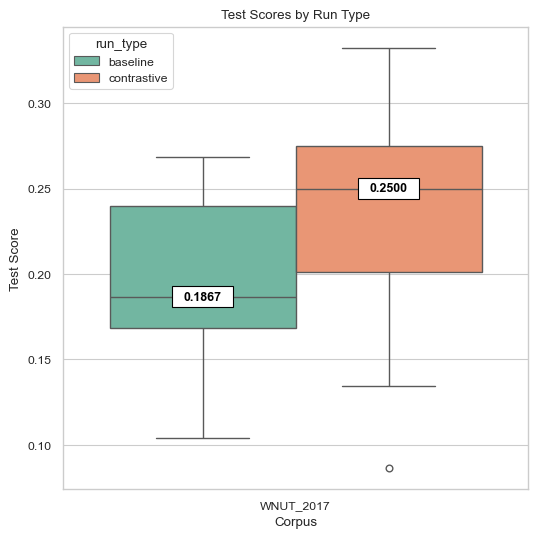

In [52]:
X_SIZE = 6
Y_SIZE = 6

plt.figure(figsize=(X_SIZE, Y_SIZE))

box_plot = sns.boxplot(x='corpus', y='test_score', data=wnut_bs64_df, hue='run_type')

plt.title('Test Scores by Run Type')
plt.xlabel('Corpus')
plt.ylabel('Test Score')

# Get the current axis
ax = plt.gca()

# Calculate the vertical offset based on the plot size
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
vertical_offset = y_range * 0.01 

x_margin = X_SIZE = 0.025
y_margin = Y_SIZE = 0.0025

sub = True
for xtick in box_plot.get_xticks():
    for median in medians_wnut[xtick]:
        text = ax.text(
            xtick-0.2 if sub else xtick+0.2, 
            median,
            f'{median:.4f}', 
            horizontalalignment='center',
            verticalalignment='center',
            size=9,
            color='black',
            weight='semibold'
        )
        
        # Get the bounding box of the text
        bbox = text.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
        
        # Convert bbox to data coordinates
        bbox_data = bbox.transformed(ax.transData.inverted())
        
        rect = plt.Rectangle((bbox_data.x0 - x_margin, bbox_data.y0 - y_margin), 
                             bbox_data.width + 2*x_margin, 
                             bbox_data.height + 2*y_margin, 
                             facecolor='white', 
                             edgecolor='black', 
                             # alpha=0.7, 
                             zorder=3)
        
        ax.add_patch(rect)
        
        # Bring the text to the front
        text.set_zorder(4)
        sub = not sub

save_path = Path(os.getcwd(), "output_figs", "bs64_baseline_wnut_fig.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [16]:
stats_inc_wnut_df = stats_per_experiment(wnut_bs64_df)
print(stats_inc_wnut_df.to_latex())

\begin{tabular}{ll}
\toprule
 & WNUT 2017 \\
Parameter &  \\
\midrule
Mean ContrastNER & 0.236329 \\
Mean Baseline & 0.195556 \\
Mean Difference & 0.040773 \\
STD Contrastner & 0.061583 \\
STD Baseline & 0.050131 \\
Higher Test Score & ContrastNER \\
\bottomrule
\end{tabular}

